In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import warnings
import imblearn

from collections import Counter

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pydot

In [2]:
train_data= pd.read_csv('data_train.csv')
train_data.dropna(axis = 0, how ='any',inplace=True) 


train_data['Num_words_text'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
max_train_sentence_length  = train_data['Num_words_text'].max()

test_data= pd.read_csv('data_test.csv')
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
1    7743
0     755
Name: sentiment, dtype: int64
8498
-------Test data--------
1    1905
0     222
Name: sentiment, dtype: int64
2127
-------------------------
Train Max Sentence Length :1206
Test Max Sentence Length :383


In [3]:
corpus = train_data['review'].values.astype('U')
# test_data['review'].values.astype('U')

In [4]:
num_words = 20000
train_max_len = 1210
test_max_len = 390

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(corpus.tolist())

# integer encode the documents
sequences = tokenizer.texts_to_sequences(corpus)
X_test  = tokenizer.texts_to_sequences(test_data['review'])

# pad documents to a max length 
X = pad_sequences(sequences, maxlen=train_max_len)
X_test = pad_sequences(X_test, maxlen=test_max_len)

# print(str(tokenizer.texts_to_sequences(['nice spot hang friend see also sunset amazing beside many option restaurant choose along'])))

In [5]:
print(X.shape)
print(X_test.shape)

(8498, 1210)
(2127, 390)


In [6]:
vec = TfidfVectorizer(stop_words='english')
resp = vec.fit_transform(corpus)
print(resp)
# print(train_data['review'])

  (0, 5077)	0.10530775416882965
  (0, 5809)	0.2298200452072474
  (0, 9533)	0.09830734044150571
  (0, 3465)	0.27385138724695707
  (0, 1414)	0.25355974490427574
  (0, 7561)	0.27385138724695707
  (0, 5253)	0.23326810256159441
  (0, 6677)	0.2298200452072474
  (0, 12902)	0.25355974490427574
  (0, 7649)	0.25355974490427574
  (0, 8249)	0.2619815373984429
  (0, 2424)	0.24168989505576158
  (0, 2770)	0.5239630747968858
  (0, 925)	0.25355974490427574
  (0, 1993)	0.10223723929298528
  (1, 12188)	0.14162804575532145
  (1, 8660)	0.24176857770655466
  (1, 9664)	0.15930429629025908
  (1, 11149)	0.18954103060944102
  (1, 6007)	0.2237623997079001
  (1, 9083)	0.2442718403710865
  (1, 1352)	0.20298986674853403
  (1, 9180)	0.2719798368310526
  (1, 3705)	0.20375935152997388
  (1, 11620)	0.13835128529491011
  :	:
  (8496, 7249)	0.1380894442246654
  (8496, 5533)	0.1191815093346397
  (8496, 13257)	0.1377456435552392
  (8496, 12188)	0.14171453753187202
  (8497, 2509)	0.42977063871457044
  (8497, 2746)	0.3606697

In [7]:
# define pipeline
over = SMOTE()
# steps = [('o', over)]
# pipeline = Pipeline(steps=steps)


# transform the dataset
X, y = over.fit_resample(X, train_data['sentiment'])

In [9]:
counter = Counter(y)
print(counter)

Counter({1: 7743, 0: 7743})


In [46]:
# One-hot encoding of labels

y_test = tf.keras.utils.to_categorical(test_data['sentiment'])
y = tf.keras.utils.to_categorical(y)

In [44]:
X.shape

(15486, 1210)

In [47]:
y.shape

(15486, 2, 2, 2, 2)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X,\
                                                      y,\
                                                      test_size=0.2,\
                                                      stratify = y,\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

# sm = SMOTE()
# x_train_res, y_train_res = sm.fit_resample(X_train, y_train)


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(X.tolist()) )

#Normal
# x_train = pad_sequences(x_train, padding='post', maxlen=1210)
# x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
# x_test = pad_sequences(x_test, padding='post', maxlen=390)

#Undersampling
x_train = pad_sequences(x_train, padding='post', maxlen=1210)
x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
x_test = pad_sequences(x_test, padding='post', maxlen=390)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

ValueError: Found array with dim 3. Estimator expected <= 2.

In [23]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Text to number
[1 1 1 1 1 1 1 1 1 1]
Number to category
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [24]:
# count =0
# print('======Train dataset ====')
# for value,label in train_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# count =0
# print('======Validation dataset ====')
# for value,label in valid_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# print('======Test dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break

In [25]:
max_features =20000
embedding_dim =64
sequence_length = 1210

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,2, padding='valid', activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Dense(64, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# model.add(tf.keras.layers.Dropout(0.3))

# model.add(tf.keras.layers.Dense(64, activation='relu',\
#                                 kernel_regularizer=regularizers.l2(0.001),\
#                                 bias_regularizer=regularizers.l2(0.001)))

# model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

# custom_early_stopping = EarlyStopping(
#     monitor='val_loss', 
#     patience=1, 
#     min_delta=0.001, 
#     mode='auto'
# )



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [26]:
import graphviz

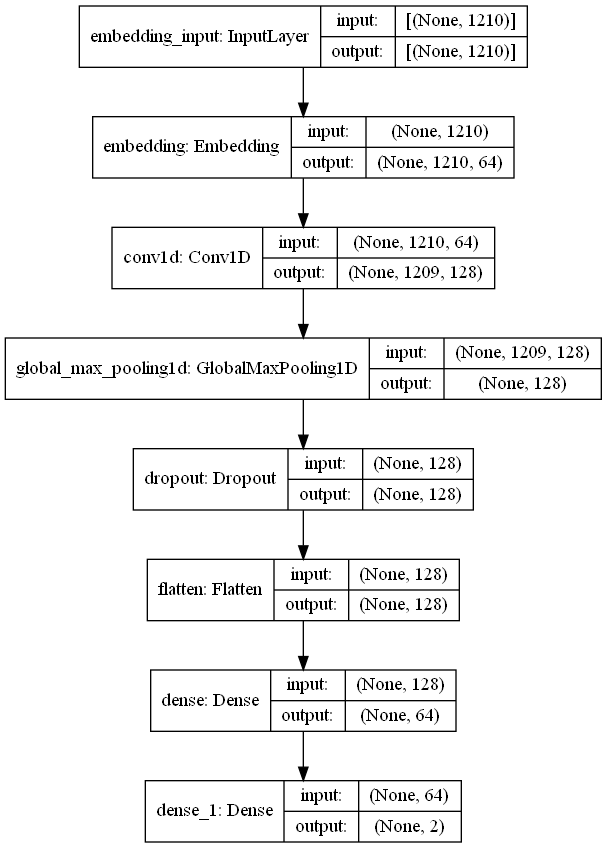

In [27]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [28]:
epochs = 3

# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(64),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(64),
                    verbose=1)

# ,
#                     callbacks=[custom_early_stopping]

Epoch 1/3


E:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


107/107 [==============================] - 28s 221ms/step - loss: 0.5141 - categorical_accuracy: 0.9101 - val_loss: 0.3522 - val_categorical_accuracy: 0.9112
Epoch 2/3
107/107 [==============================] - 22s 201ms/step - loss: 0.3070 - categorical_accuracy: 0.9112 - val_loss: 0.2909 - val_categorical_accuracy: 0.9118
Epoch 3/3
107/107 [==============================] - 21s 201ms/step - loss: 0.2530 - categorical_accuracy: 0.9259 - val_loss: 0.2501 - val_categorical_accuracy: 0.9265


In [13]:
len(history.history['loss'])

3

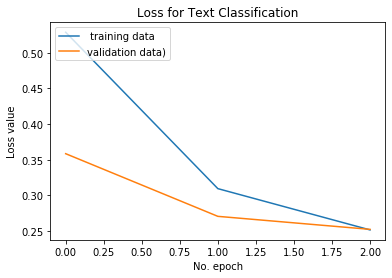

In [14]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

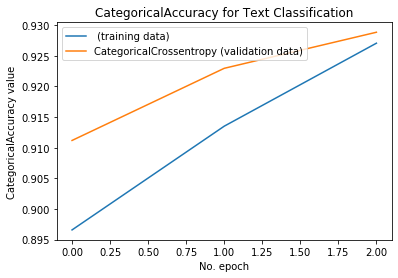

In [15]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [16]:
import pickle

model.save('WeightedModel5\\tf_cnnmodel') 

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

INFO:tensorflow:Assets written to: WeightedModel5\tf_cnnmodel\assets


In [17]:
new_model = tf.keras.models.load_model('WeightedModel5\\tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1

In [18]:
test_data = pd.read_csv('data_test.csv', converters={'reviews' : str})
# test_data.drop(["Date", "Content"], axis=1, inplace=True)
# test_data.fillna(0)
# test_data = test_data.fillna("")
test_data.sample(5)

,Date,Content,review,scores,compound,sentiment
1516,19-Oct,The most beautiful sunsets I have ever seen. S...,beautiful sunset see sit relax cold drink awes...,"{'neg': 0.0, 'neu': 0.524, 'pos': 0.476, 'comp...",0.8979,1
1193,15-Apr,"Nice beach, pretty quiet and relaxed. There ar...",nice pretty quiet relaxed arent real wave food...,"{'neg': 0.0, 'neu': 0.603, 'pos': 0.397, 'comp...",0.8481,1
735,15-Jun,"Quiet white sandy beach. Clear water, low wave...",quiet white sandy clear water low wave watch r...,"{'neg': 0.107, 'neu': 0.761, 'pos': 0.132, 'co...",0.1280,1
1507,16-Aug,But it's definitely not a pretty beach! Steepl...,definitely pretty steeply raked ocean northern...,"{'neg': 0.088, 'neu': 0.563, 'pos': 0.349, 'co...",0.9735,1
494,19-Sep,"Very nice beach for making photos. Rock, stone...",nice make photos rock stone sandy part country...,"{'neg': 0.114, 'neu': 0.655, 'pos': 0.231, 'co...",0.4019,1


In [19]:
try:
    x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
    # x_test = tokenizer
    x_test = pad_sequences(x_test, padding='post', maxlen=1210)
except AttributeError:
    pass

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.14123815 0.88940036]
 [0.1109398  0.9192805 ]
 [0.11703476 0.9159598 ]
 ...
 [0.11669034 0.9156736 ]
 [0.5986359  0.43403253]
 [0.1670239  0.8646115 ]]


In [21]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'0',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'1',test_data.pred_sentiment)

In [22]:
labels = ['0', '1']
    
print(classification_report(test_data['sentiment'].values.astype(int).astype(str),test_data['pred_sentiment'].values,labels=labels))

              precision    recall  f1-score   support

           0       0.73      0.25      0.37       222
           1       0.92      0.99      0.95      1905

    accuracy                           0.91      2127
   macro avg       0.83      0.62      0.66      2127
weighted avg       0.90      0.91      0.89      2127



In [23]:
# df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(test_data['sentiment'], test_data['pred_sentiment'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted   0     1
Actual             
0          55   167
1          20  1885


In [24]:
roc_auc = roc_auc_score(test_data['sentiment'], test_data['pred_sentiment'])

print("ROC AUC Score")
print(roc_auc)

ROC AUC Score
0.6186245300418529


In [25]:
sequence20 = tokenizer.texts_to_sequences(['perfect morning walk amazing sunrise'])


test20 = pad_sequences(sequence20, padding="post")
labels[np.around(new_model.predict(test20)).argmax(axis=1)[0]]

'1'

In [26]:
sequence30 = tokenizer.texts_to_sequences(['ugly beach'])


test30 = pad_sequences(sequence30, padding="post")
labels[np.around(new_model.predict(test30)).argmax(axis=1)[0]]

'0'